Please upload creditcard.csv


Saving creditcard.csv to creditcard (2).csv
Loaded dataset: creditcard (2).csv


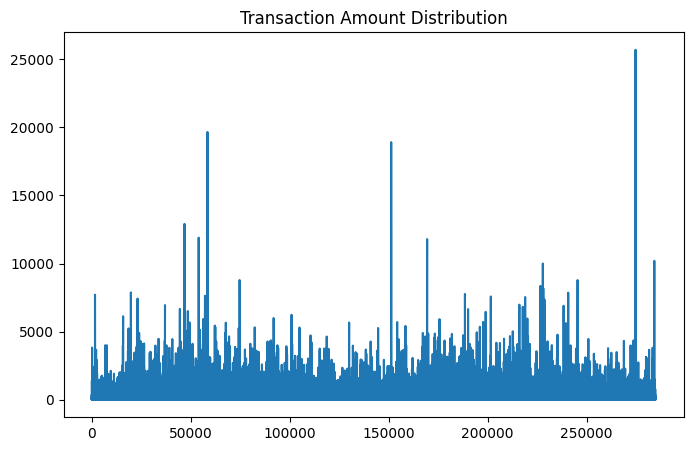

Before SMOTE: [220152    378]
After SMOTE: [220152 220152]


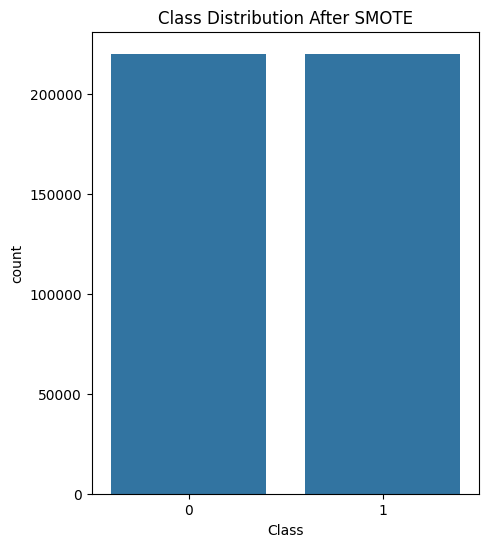


--- Logistic Regression ---
Accuracy: 99.09%
F1-Score: 0.25

--- XGBoost (SMOTE + Threshold=0.9) ---
Accuracy : 95.37%
Precision: 3.23%
Recall   : 89.47%
F1-Score : 0.06


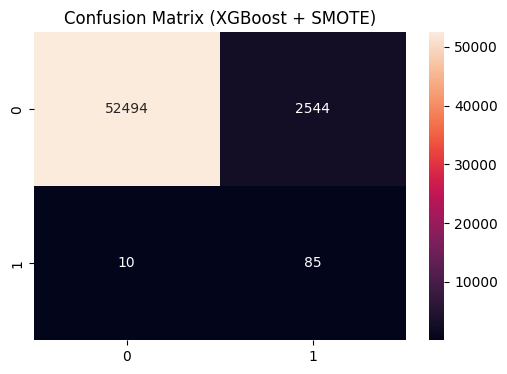

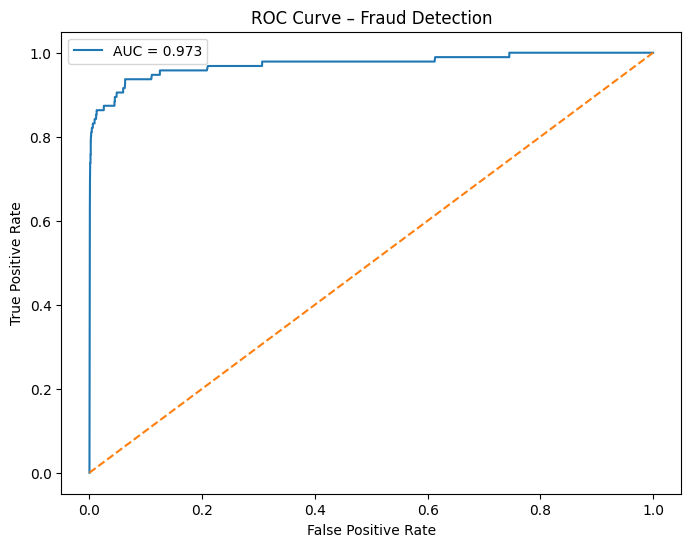

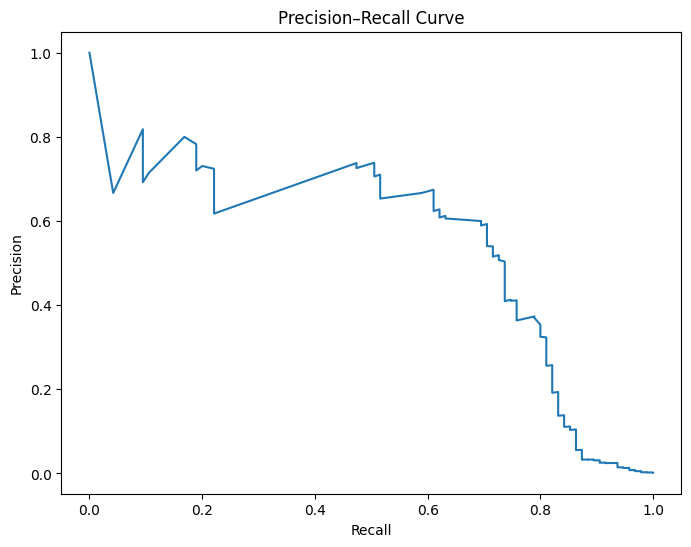


✅ FINAL PREDICTION: NOT A FRAUDULENT TRANSACTION


In [4]:

# 1. Install required libraries

!pip install -U imbalanced-learn xgboost


# 2. Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io

from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_curve, roc_auc_score,
    precision_recall_curve
)


# 3. Upload Dataset

print("Please upload creditcard.csv")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

print(f"Loaded dataset: {filename}")


# 4. Data Cleaning

df.drop(["Time"], axis=1, inplace=True)
df.drop_duplicates(inplace=True)


# 5. Amount Distribution

plt.figure(figsize=(8,5))
plt.plot(df["Amount"])
plt.title("Transaction Amount Distribution")
plt.show()


# 6. Scaling & Train-Test Split

sc = StandardScaler()
df["Amount"] = sc.fit_transform(df["Amount"].values.reshape(-1,1))

X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.8,
    stratify=y,
    random_state=42
)


# 7. APPLY SMOTE

print("Before SMOTE:", np.bincount(y_train))

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE:", np.bincount(y_train_res))


# 8. SMOTE Class Distribution

plt.figure(figsize=(5,6))
sns.countplot(x=y_train_res)
plt.title("Class Distribution After SMOTE")
plt.show()


# 9. Logistic Regression

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_res, y_train_res)

y_prob_log = log_model.predict_proba(X_test)[:,1]
y_pred_log = (y_prob_log >= 0.8).astype(int)

print("\n--- Logistic Regression ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log)*100:.2f}%")
print(f"F1-Score: {f1_score(y_test, y_pred_log):.2f}")


# 10. XGBoost (STRONGLY REGULARIZED)

xgb_model = XGBClassifier(
    max_depth=1,
    n_estimators=25,
    learning_rate=0.5,
    subsample=0.6,
    colsample_bytree=0.6,
    min_child_weight=20,
    gamma=8,
    scale_pos_weight=20,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train_res, y_train_res)

y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]
threshold = 0.9
y_pred_xgb = (y_prob_xgb >= threshold).astype(int)

print("\n--- XGBoost (SMOTE + Threshold=0.9) ---")
print(f"Accuracy : {accuracy_score(y_test, y_pred_xgb)*100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred_xgb)*100:.2f}%")
print(f"Recall   : {recall_score(y_test, y_pred_xgb)*100:.2f}%")
print(f"F1-Score : {f1_score(y_test, y_pred_xgb):.2f}")


# 11. Confusion Matrix

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d")
plt.title("Confusion Matrix (XGBoost + SMOTE)")
plt.show()


# 12. ROC Curve

fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
auc = roc_auc_score(y_test, y_prob_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Fraud Detection")
plt.legend()
plt.show()


# 13. Precision-Recall Curve

precision, recall, _ = precision_recall_curve(y_test, y_prob_xgb)

plt.figure(figsize=(8,6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()


# 14. Final Fraud Prediction Statement

if y_prob_xgb[0] >= threshold:
    print("\n🚨 FINAL PREDICTION: FRAUDULENT TRANSACTION")
else:
    print("\n✅ FINAL PREDICTION: NOT A FRAUDULENT TRANSACTION")
